In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Data preprocess

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# 整理日期格式，抓出奇數蘭整理後在指定回去
def transform_to_date(x):
    try:
        return datetime.strptime(x, "%m/%d/%Y")
    except:
        pass

data[data.columns[np.arange(0, len(data.columns), 2)]] = data.iloc[
    :, np.arange(0, len(data.columns), 2)
].applymap(lambda x: transform_to_date(x))

In [4]:
# 把columns名稱統一規格，待會才可以merge
mapper = dict(
    list(
        zip(
            data.columns[np.arange(0, len(data.columns), 2)],
            ['date'] * len(np.arange(0, len(data.columns), 2))
        )
    )
)

data.rename(columns=mapper, inplace=True)

In [5]:
# 把資料依據日期串起來
main_date_key = pd.DataFrame(data.iloc[:, 0])
main_date_key.dropna(inplace=True)

for i in np.arange(0, len(data.columns), 2):
    temp_data = data.iloc[:, i:i+2]
    temp_data = temp_data.dropna()
    main_date_key = main_date_key.merge(temp_data, on='date')
    
main_date_key.index = main_date_key.date
main_date_key.drop(columns='date', inplace=True)

main_date_key = main_date_key.applymap(lambda x: float(x))
clean_data = main_date_key

# Fitting curve

In [6]:
from scipy.optimize import curve_fit

In [7]:
x = [
    1/52, 2/52, 3/52, 1/12, 2/12, 3/12, 6/12,
    1, 2, 3, 5, 7, 10, 20, 30, 50
]

In [8]:
def function_1(t, B_0, B_1, B_2, theta):
    return (
        B_0 +
        (B_1 + B_2)*((1 - np.exp(-t/theta)) / (t/theta)) - 
        B_2*(np.exp(-t/theta))
    )

In [9]:
def function_2(t, B_0, B_1, B_2, B_3, theta, vega):
    return (
        B_0 +
        B_1 * ((1 - np.exp(-t/theta)) / (t/theta)) +
        B_2 * (((1 - np.exp(-t/theta)) / (t/theta)) - np.exp(-t/theta)) +
        B_3 * (((1 - np.exp(-t/vega)) / (t/vega)) - np.exp(-t/vega))
    )

In [10]:
def get_result(series, function):
    popt, pcov = curve_fit(
        function,
        x,
        series,
        maxfev=50000
    )
    
    fitted_data = list(map(
        lambda x: function(x, *popt),
        x
    ))
    
    MSE = sum(list(map(
        lambda x: np.power(x, 2),
        series - fitted_data
    ))) / len(series)
    
    return np.append(popt, MSE)

In [11]:
function_1_result = clean_data.apply(lambda y: get_result(y, function_1), axis=1)

function_1_result = pd.DataFrame(
    list(map(
        lambda x: x,
        function_1_result.values
    )),
    index=function_1_result.index,
    columns=['B_0', 'B_1', 'B_2', 'theta', 'MSE']
)

function_1_final_result = clean_data.copy()
function_1_final_result[function_1_result.columns.values] = function_1_result
function_1_final_result.to_csv('function_1_final_result.csv')

C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


In [12]:
function_2_result = clean_data.apply(lambda y: get_result(y, function_2), axis=1)

function_2_result = pd.DataFrame(
    list(map(
        lambda x: x,
        function_2_result.values
    )),
    index=function_2_result.index,
    columns=['B_0', 'B_1', 'B_2', 'B_3', 'theta', 'vega', 'MSE']
)

function_2_final_result = clean_data.copy()
function_2_final_result[function_2_result.columns.values] = function_2_result
function_2_final_result.to_csv('function_2_final_result.csv')

C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\andy5\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


# Plot fitted curve

In [13]:
def plot_fitted_curve(date, function):
    series = clean_data[clean_data.index == date].values[0]

    popt, pcov = curve_fit(
        function,
        x,
        series,
        maxfev=50000
    )

    fitted_data = list(map(
        lambda x: function(x, *popt),
        x
    ))

    MSE = sum(list(map(
        lambda x: np.power(x, 2),
        series - fitted_data
    ))) / len(series)
    
    print('Parameters: ')
    print(popt)
    print('MSE: ')
    print(MSE)
    
    plt.figure(figsize=(12, 8))
    plt.style.use('seaborn')
    plt.scatter(
        x,
        clean_data[clean_data.index == date].values[0],
        c='orange',
        lw=2,
        label='Data'
    );
    
    plt.plot(
        x,
        fitted_data,
        label='Fitted curve'
    )
    
    legend = plt.legend(fontsize=15, frameon = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('grey')
    plt.title('Actual data and fitted curve', fontsize=20)
    plt.xlabel('Time to maturity', fontsize=15)
    plt.ylabel('Rate', fontsize=15);

Parameters: 
[ 2.6296368  -0.20240749 -0.67272722  2.24851564]
MSE: 
0.0013346463186


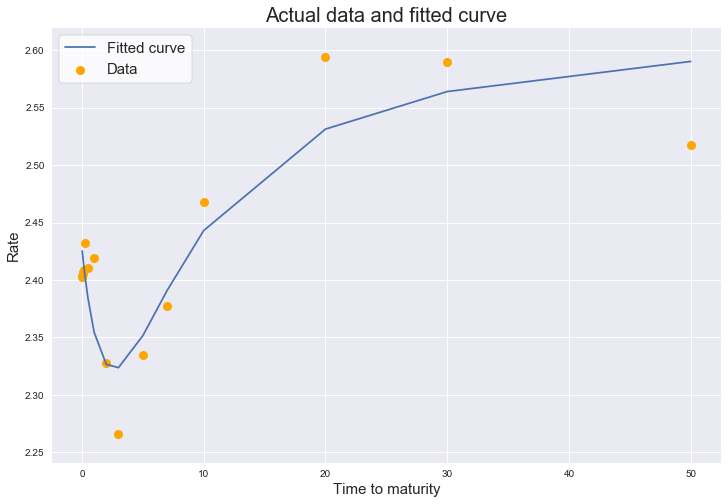

In [14]:
plot_fitted_curve('2019/3/14', function_1)

Parameters: 
[   2.61931097   -0.22785783  175.47965768 -176.08516277    0.97573945
    0.98032855]
MSE: 
0.000665327685598


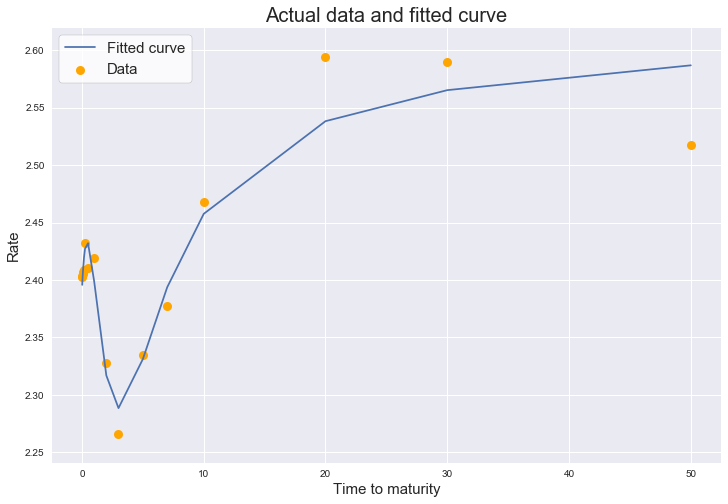

In [15]:
plot_fitted_curve('2019/3/14', function_2)

# Reference
* [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

* [Scipy curvefit RuntimeError:Optimal parameters not found: Number of calls to function has reached maxfev = 1000](https://stackoverflow.com/questions/15831763/scipy-curvefit-runtimeerroroptimal-parameters-not-found-number-of-calls-to-fun)

* [matplotlib legend background color](https://stackoverflow.com/questions/19863368/matplotlib-legend-background-color)